# Introduction/Preface

The purpose of this study is to use descriptive and inferential statistical methods to derive information from HDB apartments and their features. 

The data set used can be found at https://data.gov.sg/dataset/resale-flat-prices

# Key Assumptions
- Data used is sourced from data.gov.sg for HDB resale prices. The data set starts from January of 2017 and ends at March of 2020.



- Inflation will not be factored in. Within a three year span, inflation fluctuations affect prices by less than 0.1% (Statista, 2020).



- The research question is: Which predictor is most heavily weighted in determining resale price?
    - How can HDB apartments be classified and clustered according to their features?
    

    
- Due to time and resource constraint, only 2 variables will be chosen for the multiple linear regression. More than 2 variables might lead to overfitting of the model to the training data, resulting in sub-optimal predictive performance
    - 4 Univariate Linear Regressions will be conducted to determine which are the most heavily weighted predictors of price per square meter, followed by a Multiple Linear Regression collecting the most relevant and weighted predictors

## Reference

Statista, 2020. Singapore: Inflation rate from 1984 to 2021. https://www.statista.com/statistics/379423/inflation-rate-in-singapore/

In [44]:
import pandas as pd
import seaborn as sns
import mplleaflet
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

## Part 1: Data Cleaning and Wrangling

In [18]:
hdb_data = pd.read_csv("resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv")



hdb_data.isna().any()

month                  False
town                   False
flat_type              False
block                  False
street_name            False
storey_range           False
floor_area_sqm         False
flat_model             False
lease_commence_date    False
remaining_lease        False
resale_price           False
dtype: bool

In [19]:
hdb_data.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


#### Now we will be making a new column for price per square meter (sqm) to eliminate the effect of size of the house on the price. 
#### Then we will find the average price per sqm for each town

In [20]:
hdb_data["price_per_sqm"] = hdb_data["resale_price"]/ hdb_data["floor_area_sqm"] 
price_sqm_town_df = hdb_data[["town", "price_per_sqm"]]
price_sqm_town_df

ave_price_sqm_town = price_sqm_town_df.groupby("town").mean()

ave_price_sqm_town.head()
ave_price_sqm_town

,price_per_sqm
town,
ANG MO KIO,4713.429370
BEDOK,4540.308707
BISHAN,5922.249315
BUKIT BATOK,3960.533756
BUKIT MERAH,6383.752381
BUKIT PANJANG,4145.226581
BUKIT TIMAH,6422.787127
CENTRAL AREA,7399.124451
CHOA CHU KANG,3486.095791


#### We will now find the numer of houses sold in each town from 2017-May 2020

In [21]:
num_per_town = pd.DataFrame(hdb_data.groupby("town").size())
num_per_town=num_per_town.reset_index()
num_per_town = num_per_town.rename(columns={0:'Number'})
num_per_town.head()

,town,Number
0,ANG MO KIO,3154
1,BEDOK,3732
2,BISHAN,1375
3,BUKIT BATOK,2627
4,BUKIT MERAH,2774


#### Now we are appending the latitude and longitude of each town to our main dataframe for later analysis

In [22]:

latitudes_list = [1.3691, 1.3236, 1.3526, 1.3590, 1.2819, 1.3774, 1.3294, 1.2789, 1.3840, 1.3162,
                 1.3201, 1.3612, 1.3329, 1.3404, 1.3100, 1.3020, 1.3721, 1.3984,  1.2942, 
                 1.4491, 1.3868, 1.3554, 1.3496, 1.3343, 1.4382, 1.4304]
longitudes_list = [103.8454, 103.9273, 103.8352, 103.7637, 103.8239,103.7719, 103.8021,  103.8536,
                  103.7470, 103.7649, 103.8918, 103.8863, 103.7436, 103.7090, 103.8651, 103.8971,
                   103.9474, 103.9072, 103.7861, 103.8185, 103.8914, 103.8679, 103.9568, 
                  103.8563, 103.7890, 103.8354 ]

latitudes_df = pd.DataFrame(latitudes_list)
latitudes_df = latitudes_df.rename(columns={0:'Latitude'})

longitudes_df = pd.DataFrame(longitudes_list)
longitudes_df = longitudes_df.rename(columns={0:"Longitude"})

location_num = pd.concat([num_per_town, latitudes_df, longitudes_df], axis=1)



#### Now we will classify the towns into regions (N,S,E,W, Central) and encode them into integers (1,2,3,4,5)

In [23]:

def area_encode(x):
    if x == 'ANG MO KIO':
        return 3
    elif x ==  'BEDOK':
        return 3
    elif x == 'BISHAN':
        return 5
    elif x ==  'BUKIT BATOK':
        return 4
    elif x == 'BUKIT MERAH':
        return 5
    elif x ==  'BUKIT PANJANG':
        return 4
    elif x == 'BUKIT TIMAH':
        return 4
    elif x ==  'CENTRAL AREA':
        return 5
    elif x == 'CHOA CHU KANG':
        return 1
    elif x ==  'CLEMENTI':
        return 4
    elif x == 'GEYLANG':
        return 2
    elif x ==  'HOUGANG':
        return 1
    elif x == 'JURONG EAST':
        return 4
    elif x ==  'JURONG WEST':
        return 4
    elif x == 'KALLANG/WHAMPOA':
        return 5
    elif x == 'MARINE PARADE':
        return 2
    elif x ==  'PASIR RIS':
        return 3
    elif x == 'PUNGGOL':
        return 1
    elif x ==  'QUEENSTOWN':
        return 4
    elif x == 'SEMBAWANG':
        return 1
    elif x == 'SENGKANG':
        return 1
    elif x == 'SERANGOON':
        return 3
    elif x == 'TAMPINES':
        return 3
    elif x == 'TOA PAYOH':
        return 5
    elif x == 'WOODLANDS':
        return 1
    elif x == 'YISHUN':
        return 1 
    
hdb_data["area_int"] = hdb_data["town"].apply(area_encode)

#### Now we will encode the "flat_type" strings as integers from 1 to 7


In [24]:
hdb_data.flat_type.unique()#'2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', '1 ROOM',
       #'MULTI-GENERATION'
    
def flat_encode(x):
    if x == '1 ROOM':
        return 1
    elif x == '2 ROOM':
        return 2
    elif x== '3 ROOM':
        return 3
    elif x == '4 ROOM':
        return 4
    elif x == '5 ROOM':
        return 5
    elif x == 'EXECUTIVE':
        return 6
    elif x == 'MULTI-GENERATION':
        return 7
    
hdb_data["flat_type_int"] = hdb_data["flat_type"].apply(flat_encode)


## Part 2: Data Visualization 

### A. Visualization of number of flats sold per town, and average price_per_sqm per town depicted by the colour

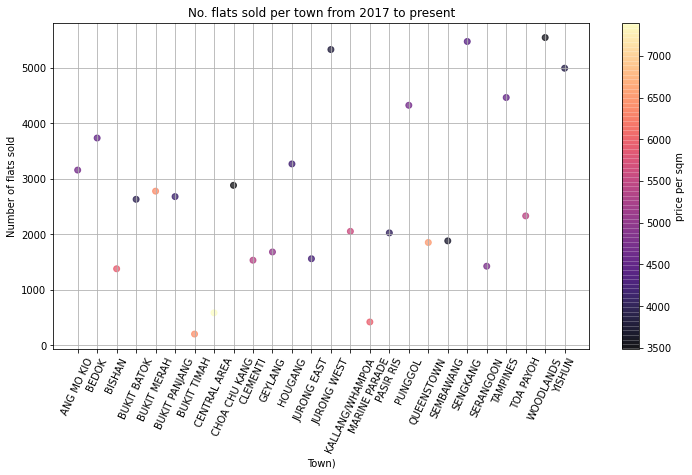

In [25]:
plt.figure(figsize=(12, 6))
plt.title("No. flats sold per town from 2017 to present")
plt.xlabel("Town)")
plt.ylabel("Number of flats sold")
plt.scatter(num_per_town.town, num_per_town.Number, c=ave_price_sqm_town.price_per_sqm, cmap="magma", alpha=0.7)
plt.colorbar(label="price per sqm")
plt.xticks(rotation=65)
plt.grid(True)
plt.show()


### B. Visualization of number of flats sold (from 2017-May 2020) per area, represented on a map where a bigger and darker red circle represents a higher number of flats

In [26]:
from collections import Counter

plt.figure(figsize=(16, 8))
plt.scatter(location_num.Longitude, location_num.Latitude, c=location_num.Number, s=location_num.Number, alpha=0.5, cmap='Reds')
mplleaflet.display()

### C. Visualization of price per sqm of different flat types, with the colour representing the region
#### Flat types are encoded as such: 1 = 1-room flat; 2 = 2-room flat; 3 = 3-room flat; 4 = 4-room flat; 5 = 5-room flat; 6 = multi-generation; 6 = executive
#### Region is encoded as such: 1 = North, 2 = South; 3 = East; 4 = West; 5 = Central
#### The colours go from yellow (1) to red (5)

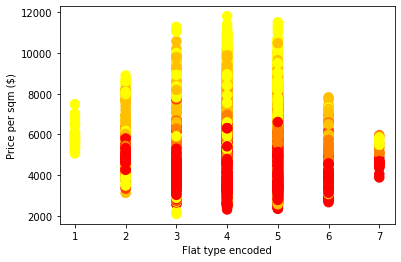

In [27]:
### more data visualizations

#### flat type and price; colour represents region
#### red is 0 (north) --> yellow is 5 (central)
plt.scatter(x=hdb_data.flat_type_int, 
               y=hdb_data.price_per_sqm, c=hdb_data.area_int, cmap='autumn'
              ,marker="o", s=90)
plt.xlabel("Flat type encoded")
plt.ylabel("Price per sqm ($)")
plt.show()


In [28]:
hdb_data.head()


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,price_per_sqm,area_int,flat_type_int
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,5272.727273,3,2
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,3731.343284,3,3
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,3910.447761,3,3
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,3897.058824,3,3
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,3955.223881,3,3


## Part 3: Further data wrangling for machine learning

#### We will now extract the first 2 positions of the "remaining lease" string and converting it to integer form

In [29]:
def convert_date(text):
    return int(text[0:2])

hdb_data["remaining_lease_int"] = hdb_data["remaining_lease"].apply(convert_date)
hdb_data.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,price_per_sqm,area_int,flat_type_int,remaining_lease_int
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,5272.727273,3,2,61
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,3731.343284,3,3,60
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,3910.447761,3,3,62
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,3897.058824,3,3,62
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,3955.223881,3,3,62


#### Now we take the "storey_range" string and convert it to an integer which has the average of the extremes of the range

In [30]:
def storey_ave(text):
    return int(text[0:2]) + 1
hdb_data["storey_ave"] = hdb_data["storey_range"].apply(storey_ave)
hdb_data.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,price_per_sqm,area_int,flat_type_int,remaining_lease_int,storey_ave
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,5272.727273,3,2,61,11
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,3731.343284,3,3,60,2
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,3910.447761,3,3,62,2
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,3897.058824,3,3,62,5
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,3955.223881,3,3,62,2


# Part 4: Machine Learning 

## Part 4A: Linear regression 

# Univariate Linear Regression: Checking for the most significant predictor of Price per Square Meter

There will be a total of 4 univariate linear regressions done to cross check predictors and their impact on the price per square meter.


# Univariate Linear Regression #1:
### Independent Variable (X): Town
### Dependent Variable (y): Price Per Square Meter

In [31]:
dep_var1 = hdb_data["price_per_sqm"]
ind_var1 = hdb_data[["town"]]

# One Hot Encoding for Categorical Variables
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

ind_var1_xformed = ohe.fit_transform(ind_var1).toarray()

# Creating train test split with random_state = 42
from sklearn.model_selection import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(ind_var1_xformed, dep_var1, train_size = 0.8, test_size = 0.2, random_state = 42)



# Training the model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
regression1 = model.fit(X_train1, y_train1)


print(regression1.coef_)
print(regression1.intercept_)
print(regression1.score(X_test1, y_test1))

[-1.30494731e+14 -1.30494731e+14 -1.30494731e+14 -1.30494731e+14
 -1.30494731e+14 -1.30494731e+14 -1.30494731e+14 -1.30494731e+14
 -1.30494731e+14 -1.30494731e+14 -1.30494731e+14 -1.30494731e+14
 -1.30494731e+14 -1.30494731e+14 -1.30494731e+14 -1.30494731e+14
 -1.30494731e+14 -1.30494731e+14 -1.30494731e+14 -1.30494731e+14
 -1.30494731e+14 -1.30494731e+14 -1.30494731e+14 -1.30494731e+14
 -1.30494731e+14 -1.30494731e+14]
130494731486881.39
0.47156374790616956


## Visualizing the Predictions of Regression #1

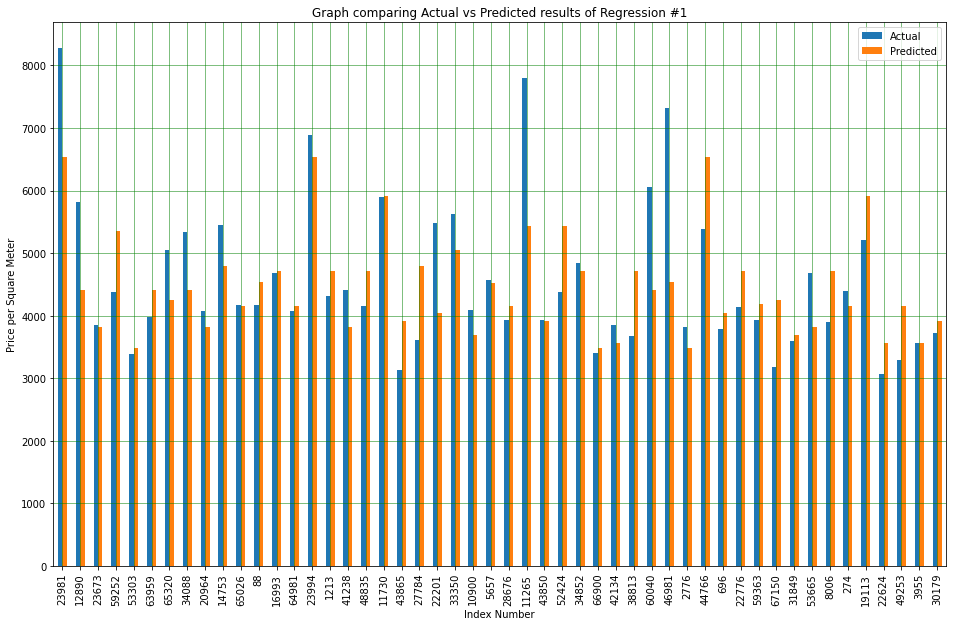

In [32]:
# Using Bar Chart
y_pred1 = regression1.predict(X_test1)

compare_df1 = pd.DataFrame({"Actual": y_test1, "Predicted": y_pred1})

import matplotlib.pyplot as plt

truncated_df = compare_df1.head(50)

truncated_df.plot(kind = "bar", figsize = (16,10))
plt.grid(which = "major", linestyle = "-", linewidth = "0.5", color = "green")
plt.grid(which = "minor", linestyle = "-", linewidth = "0.5", color = "black")
plt.title("Graph comparing Actual vs Predicted results of Regression #1")
plt.ylabel("Price per Square Meter")
plt.xlabel("Index Number")
plt.show()

## Visualizing overall performance metrics of Regression #1

### Decoding One Hot Encoded Variables


In [33]:
# Decoding One Hot Encoded categories
town_list = list(hdb_data.loc[:, "town"])

def remove_dup(dups):
    final_list =[]
    for x in dups:
        if x not in final_list:
            final_list.append(x)
    return final_list

town_list_no_dup = remove_dup(town_list)



In [34]:
import statsmodels.api as sm

# X_train1 = sm.add_constant(X_train1)

statsmodel1 = sm.OLS(y_train1.astype(float), X_train1.astype(float)).fit()

display(statsmodel1.summary(xname = town_list_no_dup))
from sklearn.metrics import mean_squared_error
print(regression1.score(X_test1, y_test1))
print(mean_squared_error(y_test1, y_pred1))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          price_per_sqm   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     2026.
Date:                Thu, 02 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:36:45   Log-Likelihood:            -4.5955e+05
No. Observations:               56082   AIC:                         9.191e+05
Df Residuals:                   56056   BIC:                         9.194e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
ANG MO KIO       4720.6736     17.508    269.633      0.000    4686.358    4754.989
BEDOK            4538.0278     15.863    286.068      0.000    4506.935    4569.120
BISHAN           5921.1642     26.524    223.240      0.000    5869.177    5973.151
BUKIT BATOK      3955.8345     19.018    208.000      0.000    3918.558    3993.111
BUKIT MERAH      6384.0452     18.421    346.573      0.000    6347.941    6420.149
BUKIT PANJANG    4156.5887     19.118    217.420      0.000    4119.118    4194.060
BUKIT TIMAH      6439.6364     70.828     90.920      0.000    6300.814    6578.459
CENTRAL AREA     7387.6321     40.759    181.250      0.000    7307.744    7467.521
CHOA CHU KANG    3489.9668     18.449    189.168      0.000    3453.806    3526.127
CLEMENTI         5353.2262     25.000    214.125      0.000    5304.225    5402.227
GEYLANG          5044.9701     23.996    210.245      0.000    4997.938    5092.002
HOUGANG          4186.7951     17.285    242.223      0.000    4152.917    4220.674
JURONG EAST      4253.6452     24.720    172.071      0.000    4205.193    4302.097
JURONG WEST      3815.9025     13.435    284.018      0.000    3789.569    3842.236
KALLANG/WHAMPOA  5590.9577     21.773    256.780      0.000    5548.282    5633.633
MARINE PARADE    5947.8245     47.653    124.816      0.000    5854.425    6041.225
PASIR RIS        4035.9532     21.713    185.877      0.000    3993.396    4078.511
PUNGGOL          4727.1488     14.853    318.257      0.000    4698.036    4756.261
QUEENSTOWN       6540.8780     22.757    287.417      0.000    6496.273    6585.483
SEMBAWANG        3695.4384     22.590    163.584      0.000    3651.161    3739.716
SENGKANG         4416.0010     13.299    332.067      0.000    4389.936    4442.066
SERANGOON        4786.2957     25.925    184.623      0.000    4735.483    4837.108
TAMPINES         4518.3579     14.634    308.757      0.000    4489.675    4547.041
TOA PAYOH        5432.8334     20.265    268.092      0.000    5393.114    5472.553
WOODLANDS        3562.4601     13.142    271.075      0.000    3536.702    3588.218
YISHUN           3917.6002     13.825    283.380      0.000    3890.504    3944.696
==============================================================================
Omnibus:                     9602.877   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23762.770
Skew:                           0.961   Prob(JB):                         0.00
Kurtosis:                       5.545   Cond. No.                         5.39
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

0.47156374790616956
759110.5594931572


## Interpretation of Regression #1:

The R-squared value show that 47.5% of the price per sqm is predicted by the town that the HDB apartment belongs to. This may indicate that the linear regression model is not fit well to the training data set.

The high F-statistic value and Prob(F-statistic) value equal to zero signifies a linear relationship between independent and dependent variables.

The model experienced a markedly large standard error when trying to predict HDB prices per square meter in BUKIT TIMAH than any other area.

All categories illustrate statistical significance in the t-test. All P values are < 0.05, with no extremely no t-scores. This illustrates that the weight values of these towns are non-zero in influencing the price per square meter of an HDB apartment.

The value of the Mean Squared Error implies that the line of best fit is far away from the individual data points.

# Univariate Linear Regression #2:
### Independent Variable (X): Flat Type
### Dependent Variable (y): Price Per Square Meter

In [35]:
dep_var2 = hdb_data["price_per_sqm"]
ind_var2 = hdb_data[["flat_type"]]

# One Hot Encoding for Categorical Variables
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
ind_var2_xformed = ohe.fit_transform(ind_var2).toarray()

# Creating train test split with random_state = 42
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(ind_var2_xformed, dep_var2, train_size = 0.8, test_size = 0.2, random_state = 42)

# Training the model
from sklearn.linear_model import LinearRegression
model2 = LinearRegression()
regression2 = model2.fit(X_train2, y_train2)


print(regression2.coef_)
print(regression2.intercept_)
print(regression2.score(X_test2, y_test2))


[1.16617607e+15 1.16617607e+15 1.16617607e+15 1.16617607e+15
 1.16617607e+15 1.16617607e+15 1.16617607e+15]
-1166176074366413.2
0.007190527910548639


## Visualizing the Predictions of Regression #2:

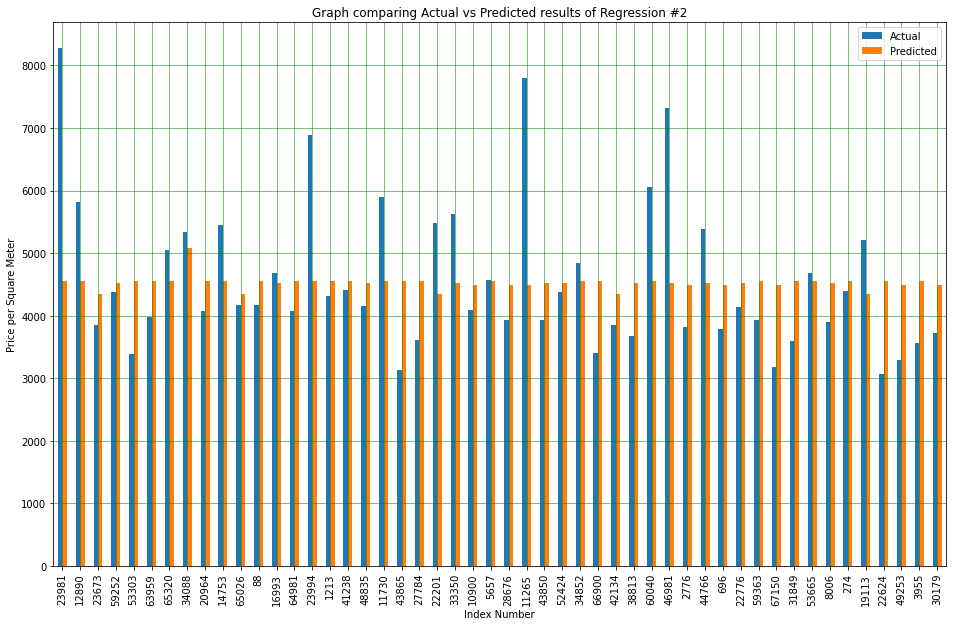

In [36]:
y_pred2 = regression2.predict(X_test2)

compare_df2 = pd.DataFrame({"Actual": y_test2, "Predicted": y_pred2})

import matplotlib.pyplot as plt

truncated_df2 = compare_df2.head(50)

truncated_df2.plot(kind = "bar", figsize = (16,10))
plt.grid(which = "major", linestyle = "-", linewidth = "0.5", color = "green")
plt.grid(which = "minor", linestyle = "-", linewidth = "0.5", color = "black")
plt.title("Graph comparing Actual vs Predicted results of Regression #2")
plt.ylabel("Price per Square Meter")
plt.xlabel("Index Number")
plt.show()

## Visualizing overall performance metrics of Regression #2

### Decoding One Hot Encoded Variables


In [37]:
types_list = list(hdb_data.loc[:, "flat_type"])

def remove_dup(dups):
    final_list =[]
    for x in dups:
        if x not in final_list:
            final_list.append(x)
    return final_list

types_list_no_dup = remove_dup(types_list)

import statsmodels.api as sm

statsmodel2 = sm.OLS(y_train2.astype(float), X_train2.astype(float)).fit()

display(statsmodel2.summary(xname=types_list_no_dup))
from sklearn.metrics import mean_squared_error
print(regression2.score(X_test2, y_test2))
print(mean_squared_error(y_test2, y_pred2))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          price_per_sqm   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     59.54
Date:                Thu, 02 Jul 2020   Prob (F-statistic):           7.59e-74
Time:                        21:36:46   Log-Likelihood:            -4.7742e+05
No. Observations:               56082   AIC:                         9.549e+05
Df Residuals:                   56075   BIC:                         9.549e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
2 ROOM            5928.0877    240.951     24.603      0.000    5455.823    6400.353
3 ROOM            5082.9419     42.021    120.963      0.000    5000.581    5165.303
4 ROOM            4511.7389     10.346    436.073      0.000    4491.460    4532.018
5 ROOM            4556.7016      7.899    576.867      0.000    4541.219    4572.184
EXECUTIVE         4487.3051     10.203    439.795      0.000    4467.307    4507.303
1 ROOM            4331.8491     18.076    239.643      0.000    4296.419    4367.279
MULTI-GENERATION  4886.2283    219.957     22.214      0.000    4455.111    5317.345
==============================================================================
Omnibus:                    17668.555   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            51479.465
Skew:                           1.669   Prob(JB):                         0.00
Kurtosis:                       6.300   Cond. No.                         30.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

0.007190527910548639
1426193.132741599


## Interpretation of Regression #2:

The R-squared value show that 0.07% of the price per sqm is predicted by the type of the flat. This strongly suggests that the linear regression has a poor fit.

The flat type does not look to be a good predictor of price per square meter.

The regression model experiences a Mean Squared Error of 1426193.1, which is a sign of poor fitting.


# Univariate Linear Regression #3:
### Independent Variable (X): Remaining Lease Duration (in years)
### Dependent Variable (y): Price Per Square Meter

In [38]:
dep_var3 = hdb_data["price_per_sqm"]
ind_var3 = hdb_data[["remaining_lease_int"]]

# Creating train test split with random_state = 42
from sklearn.model_selection import train_test_split
X_train3, X_test3, y_train3, y_test3 = train_test_split(ind_var3, dep_var3, train_size = 0.8, test_size = 0.2, random_state = 42)

# Training the model
from sklearn.linear_model import LinearRegression
model3 = LinearRegression()
regression3 = model3.fit(X_train3, y_train3)

print(regression3.coef_)
print(regression3.intercept_)
print(regression3.score(X_test3, y_test3))


[25.2137548]
2649.4195379462312
0.06779911361638336


## Visualizing the Predictions of Regression #3:

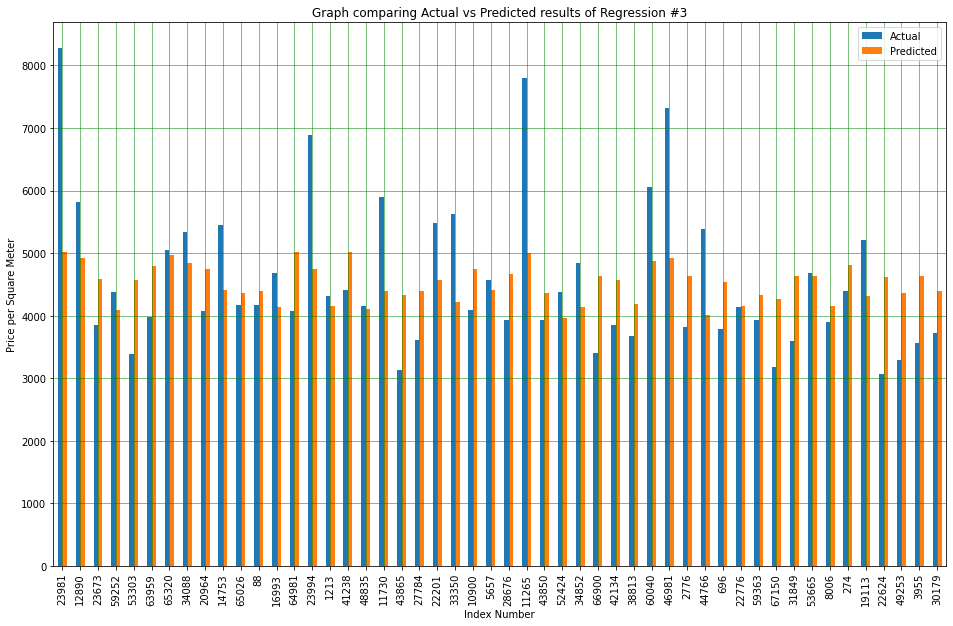

In [39]:
y_pred3 = regression3.predict(X_test3)

compare_df3 = pd.DataFrame({"Actual": y_test3, "Predicted": y_pred3})

import matplotlib.pyplot as plt

truncated_df3 = compare_df3.head(50)

truncated_df3.plot(kind = "bar", figsize = (16,10))
plt.grid(which = "major", linestyle = "-", linewidth = "0.5", color = "green")
plt.grid(which = "minor", linestyle = "-", linewidth = "0.5", color = "black")
plt.title("Graph comparing Actual vs Predicted results of Regression #3")
plt.ylabel("Price per Square Meter")
plt.xlabel("Index Number")
plt.show()

## Visualizing overall performance metrics of Regression #3

In [40]:
import statsmodels.api as sm

statsmodel3 = sm.OLS(y_train3.astype(float), X_train3.astype(float)).fit()

display(statsmodel3.summary())
from sklearn.metrics import mean_squared_error
print(regression3.score(X_test3, y_test3))
print(mean_squared_error(y_test3, y_pred3))


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          price_per_sqm   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                          7.325e+05
Date:                Thu, 02 Jul 2020   Prob (F-statistic):                        0.00
Time:                        21:36:47   Log-Likelihood:                     -4.7938e+05
No. Observations:               56082   AIC:                                  9.588e+05
Df Residuals:                   56081   BIC:                                  9.588e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
remaining_lease_int    59.9398      0.070    855.883      0.000      59.803      60.077
==============================================================================
Omnibus:                     6374.709   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8806.849
Skew:                           0.918   Prob(JB):                         0.00
Kurtosis:                       3.628   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

0.06779911361638336
1339127.536422375


## Interpretation of Regression #3:
There is a large discrepancy between the R-squared score derived from the statsmodels.api and the sklearn library.

# Univariate Linear Regression #4:
### Independent Variable (X): Storey Range
### Dependent Variable (y): Price Per Square Meter

In [41]:
dep_var4 = hdb_data["price_per_sqm"]
ind_var4 = hdb_data[["storey_range"]]

# One Hot Encoding for Categorical Variables
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

ind_var4_xformed = ohe.fit_transform(ind_var4).toarray()

# Creating train test split with random_state = 42
from sklearn.model_selection import train_test_split

X_train4, X_test4, y_train4, y_test4 = train_test_split(ind_var4_xformed, dep_var4, train_size = 0.8, test_size = 0.2, random_state = 42)



# Training the model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
regression4 = model.fit(X_train4, y_train4)


print(regression4.coef_)
print(regression4.intercept_)
print(regression4.score(X_test4, y_test4))

[9.98041611e+14 9.98041611e+14 9.98041611e+14 9.98041611e+14
 9.98041611e+14 9.98041611e+14 9.98041611e+14 9.98041611e+14
 9.98041611e+14 9.98041611e+14 9.98041611e+14 9.98041611e+14
 9.98041611e+14 9.98041611e+14 9.98041611e+14 9.98041611e+14
 9.98041611e+14]
-998041611395605.1
0.2484900095292464


## Visualizing the Predictions of Regression #4:

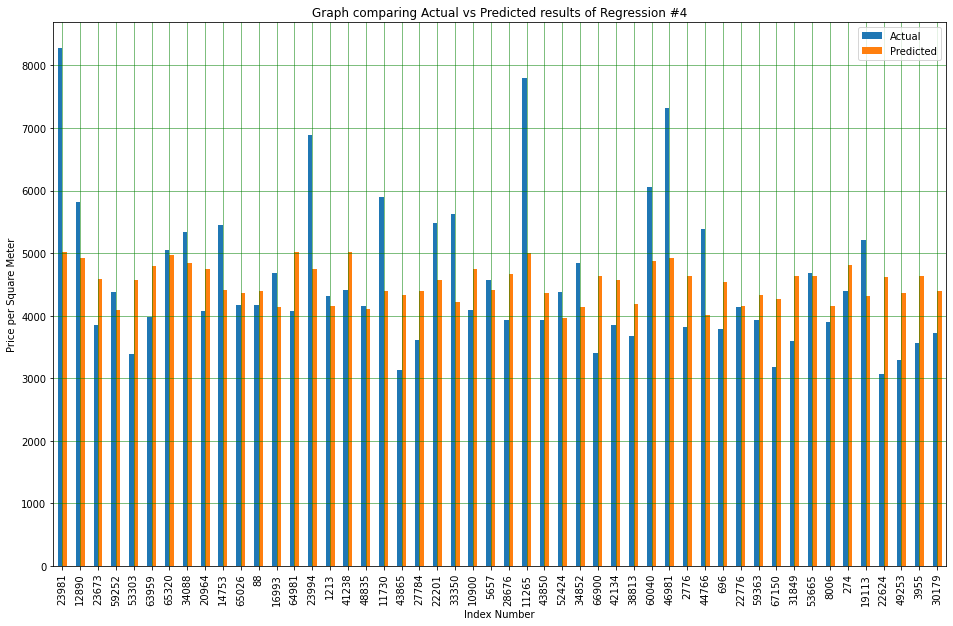

In [42]:
y_pred4 = regression4.predict(X_test4)

compare_df4 = pd.DataFrame({"Actual": y_test4, "Predicted": y_pred4})

import matplotlib.pyplot as plt

truncated_df4 = compare_df3.head(50)

truncated_df4.plot(kind = "bar", figsize = (16,10))
plt.grid(which = "major", linestyle = "-", linewidth = "0.5", color = "green")
plt.grid(which = "minor", linestyle = "-", linewidth = "0.5", color = "black")
plt.title("Graph comparing Actual vs Predicted results of Regression #4")
plt.ylabel("Price per Square Meter")
plt.xlabel("Index Number")
plt.show()

## Visualizing overall performance metrics of Regression #4

In [43]:
storey_list = list(hdb_data.loc[:, "storey_range"])

def remove_dup(dups):
    final_list =[]
    for x in dups:
        if x not in final_list:
            final_list.append(x)
    return final_list

storey_list_no_dup = remove_dup(storey_list)

import statsmodels.api as sm

statsmodel4 = sm.OLS(y_train4.astype(float), X_train4.astype(float)).fit()

display(statsmodel4.summary(xname=storey_list_no_dup))
from sklearn.metrics import mean_squared_error
print(regression4.score(X_test4, y_test4))
print(mean_squared_error(y_test4, y_pred4))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          price_per_sqm   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     1231.
Date:                Thu, 02 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:36:48   Log-Likelihood:            -4.6915e+05
No. Observations:               56082   AIC:                         9.383e+05
Df Residuals:                   56065   BIC:                         9.385e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
10 TO 12    4069.3805     10.374    392.250      0.000    4049.047    4089.715
01 TO 03    4265.4981      9.112    468.137      0.000    4247.639    4283.357
04 TO 06    4397.4677      9.520    461.921      0.000    4378.808    4416.127
07 TO 09    4500.2737     10.074    446.741      0.000    4480.529    4520.018
13 TO 15    4808.1958     14.460    332.513      0.000    4779.854    4836.538
19 TO 21    5224.5531     21.485    243.178      0.000    5182.443    5266.663
22 TO 24    5985.4529     31.800    188.221      0.000    5923.124    6047.782
16 TO 18    6088.7927     37.915    160.591      0.000    6014.479    6163.106
34 TO 36    6840.0158     50.794    134.662      0.000    6740.459    6939.572
28 TO 30    7713.3729     63.159    122.127      0.000    7589.581    7837.165
37 TO 39    8503.8352    101.954     83.409      0.000    8304.006    8703.665
49 TO 51    8454.3155     94.521     89.444      0.000    8269.055    8639.576
25 TO 27    8854.8691     98.245     90.131      0.000    8662.309    9047.430
40 TO 42    8983.0802    138.939     64.655      0.000    8710.758    9255.402
31 TO 33    1.051e+04    464.980     22.607      0.000    9600.427    1.14e+04
46 TO 48    1.054e+04    346.575     30.401      0.000    9856.784    1.12e+04
43 TO 45    1.068e+04    424.466     25.150      0.000    9843.241    1.15e+04
==============================================================================
Omnibus:                    12387.686   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28561.113
Skew:                           1.252   Prob(JB):                         0.00
Kurtosis:                       5.440   Cond. No.                         51.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

0.2484900095292464
1079561.0011056836


##  Interpretation of Regression #4:

# Multiple Linear Regression Model
### Independent Variables (X): Town, Storey Range
### Dependent Variable (y): Price per Square Meter

The X's were picked based on their R-squared and Mean Squared Error scores. Based on the 4 univariate regressions conducted, Town and Storey Range yielded the most promising performance metrics.

In [44]:
dep_var = hdb_data["price_per_sqm"]
ind_vars = hdb_data[["town", "storey_range"]]

# One Hot Encoding for Categorical Variables
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
ind_vars_xformed = ohe.fit_transform(ind_vars).toarray()

# Creating train test split with random_state = 42
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(ind_vars_xformed, dep_var, train_size = 0.8, test_size = 0.2, random_state = 42)

# Training the model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
multi_regression = model.fit(X_train, y_train)


print(multi_regression.coef_)
print(multi_regression.intercept_)
print(multi_regression.score(X_test, y_test))


[-1.54023911e+13 -1.54023911e+13 -1.54023911e+13 -1.54023911e+13
 -1.54023911e+13 -1.54023911e+13 -1.54023911e+13 -1.54023911e+13
 -1.54023911e+13 -1.54023911e+13 -1.54023911e+13 -1.54023911e+13
 -1.54023911e+13 -1.54023911e+13 -1.54023911e+13 -1.54023911e+13
 -1.54023911e+13 -1.54023911e+13 -1.54023911e+13 -1.54023911e+13
 -1.54023911e+13 -1.54023911e+13 -1.54023911e+13 -1.54023911e+13
 -1.54023911e+13 -1.54023911e+13 -2.16216630e+03 -1.97282408e+03
 -1.84530305e+03 -1.72064764e+03 -1.45794603e+03 -1.19495466e+03
 -7.38991514e+02 -6.23078559e+02 -6.35572062e+01  5.57326403e+02
  1.03316767e+03  1.04703034e+03  1.36757891e+03  1.47564159e+03
  2.03699095e+03  2.06127478e+03  2.20039952e+03]
15402391151393.352
0.5998736716183273


## Visualizing the Predictions of Multiple Regression

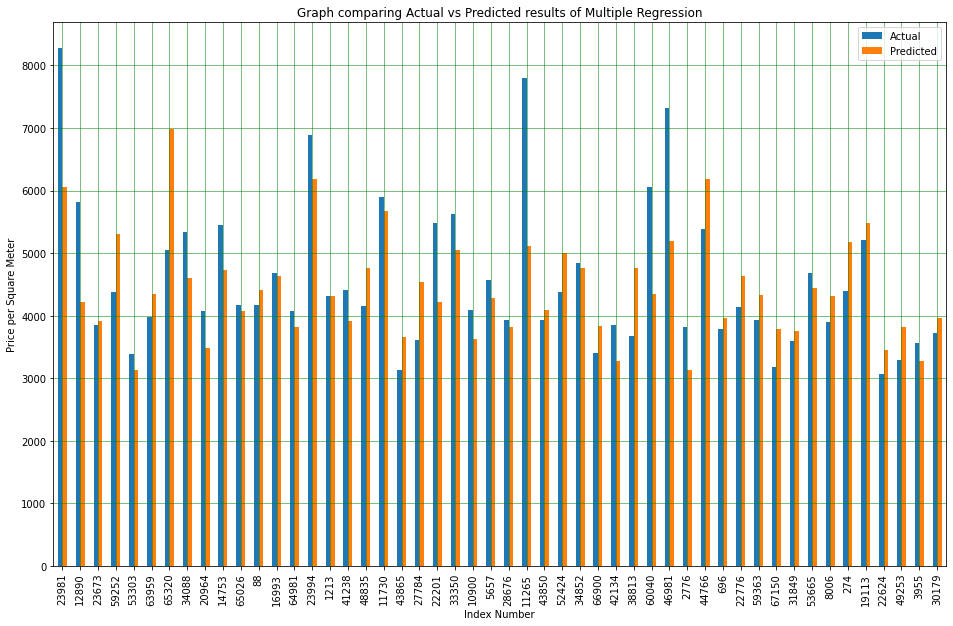

In [45]:
y_pred = multi_regression.predict(X_test)

compare_df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})

import matplotlib.pyplot as plt

truncated_df = compare_df.head(50)

truncated_df.plot(kind = "bar", figsize = (16,10))
plt.grid(which = "major", linestyle = "-", linewidth = "0.5", color = "green")
plt.grid(which = "minor", linestyle = "-", linewidth = "0.5", color = "black")
plt.title("Graph comparing Actual vs Predicted results of Multiple Regression")
plt.ylabel("Price per Square Meter")
plt.xlabel("Index Number")
plt.show()

## Visualizing overall performance metrics of Multiple Regression

In [46]:
list1 = list(hdb_data.loc[:, "town"])
list2 = list(hdb_data.loc[:, "storey_range"])


def remove_dup(dups):
    final_list =[]
    for x in dups:
        if x not in final_list:
            final_list.append(x)
    return final_list

no_dups1 = remove_dup(list1)
no_dups2 = remove_dup(list2)

total_list = no_dups1 + no_dups2

import statsmodels.api as sm

statsmodel = sm.OLS(y_train.astype(float), X_train.astype(float)).fit()
display(statsmodel.summary())
# display(statsmodel.summary(xname= total_list))
from sklearn.metrics import mean_squared_error
print(multi_regression.score(X_test, y_test))
print(mean_squared_error(y_test, y_pred))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          price_per_sqm   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     2110.
Date:                Thu, 02 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:21:02   Log-Likelihood:            -4.5142e+05
No. Observations:               56082   AIC:                         9.029e+05
Df Residuals:                   56040   BIC:                         9.033e+05
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          2489.7973     20.175    123.411      0.000    2450.255    2529.340
x2          2394.9590     19.267    124.306      0.000    2357.196    2432.722
x3          3655.6379     26.188    139.592      0.000    3604.309    3706.967
x4          1789.8929     21.177     84.522      0.000    1748.387    1831.399
x5          3879.8895     20.498    189.280      0.000    3839.713    3920.066
x6          1806.8991     21.141     85.469      0.000    1765.463    1848.335
x7          4295.7783     61.426     69.934      0.000    4175.383    4416.173
x8          4482.3072     35.037    127.929      0.000    4413.634    4550.981
x9          1297.2128     20.819     62.309      0.000    1256.408    1338.018
x10         3038.1971     25.050    121.283      0.000    2989.098    3087.296
x11         2903.7313     24.549    118.282      0.000    2855.615    2951.848
x12         2055.1516     20.141    102.041      0.000    2015.676    2094.627
x13         1958.2648     24.849     78.808      0.000    1909.561    2006.968
x14         1648.9083     17.890     92.171      0.000    1613.844    1683.972
x15         3231.8444     22.812    141.673      0.000    3187.133    3276.556
x16         3689.0523     42.543     86.714      0.000    3605.668    3772.436
x17         1941.9316     23.024     84.342      0.000    1896.804    1987.060
x18         2457.8726     18.733    131.208      0.000    2421.157    2494.589
x19         3911.6701     23.257    168.197      0.000    3866.087    3957.253
x20         1479.8021     23.575     62.769      0.000    1433.594    1526.010
x21         2075.0273     17.761    116.830      0.000    2040.216    2109.839
x22         2708.1875     25.958    104.330      0.000    2657.310    2759.065
x23         2444.6551     18.631    131.212      0.000    2408.138    2481.173
x24         2974.7768     21.616    137.618      0.000    2932.409    3017.145
x25         1437.8239     17.771     80.910      0.000    1402.993    1472.654
x26         1823.0441     18.176    100.300      0.000    1787.419    1858.669
x27         1830.3215     15.522    117.916      0.000    1799.898    1860.745
x28         2019.6684     15.066    134.057      0.000    1990.139    2049.197
x29         2147.1941     15.181    141.443      0.000    2117.440    2176.948
x30         2271.8518     15.374    147.771      0.000    2241.718    2301.985
x31         2534.5357     17.083    148.366      0.000    2501.053    2568.019
x32         2797.5354     20.431    136.928      0.000    2757.491    2837.580
x33         3253.5035     26.335    123.542      0.000    3201.886    3305.121
x34         3369.4158     30.235    111.439      0.000    3310.154    3428.677
x35         3928.9366     38.664    101.617      0.000    3853.155    4004.718
x36         4549.8222     47.109     96.580      0.000    4457.488    4642.157
x3

0.5998736716183273
574790.4686747749


## Interpretation of Multiple Regression:

The model, when factoring in 2 predictors, is able to explain 60% of the training data and 59% of the testing data. However, the Mean Squared Score is extremely large, implying a poorly fit regression line.

According to the summary table, predictors number 41 to 43 have a comparably higher standard error and lower t-value than the rest of the predictors. Given more resources, the model could be further fine-tuned using feature engineering techniques to improve the R-squared score while mitigating overfitting.

## Part 4B: K-means clustering

#### B1. storey_int and price per sqm
#### B2. region and price per sqm
#### B3. flat type and price per sqm

### B1. storey_int and price per sqm

In [47]:
df_1 = hdb_data[["storey_ave", "price_per_sqm"]]
df_1_labels = hdb_data[["storey_ave", "price_per_sqm"]]
distorsions_1 = []


Text(0.5, 1.0, 'Elbow Plot 1')

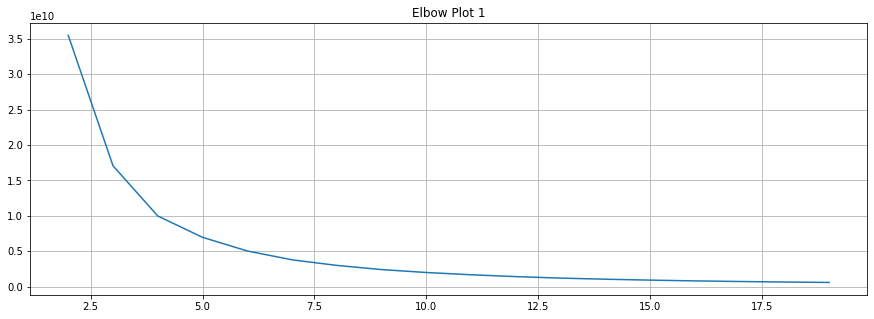

In [48]:
#elbow plot 1

from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

for k in range(2,20):
    kmeans_1 = KMeans(n_clusters=k)
    kmeans_1.fit(df_1)
    distorsions_1.append(kmeans_1.inertia_)

fig_1 = plt.figure(figsize=(15,5))
plt.plot(range(2,20), distorsions_1)
plt.grid(True)
plt.title("Elbow Plot 1")


In [49]:
k_1 = 4
model_1 = KMeans(n_clusters=k_1, random_state=0)
hdb_kmeans_1 = model_1.fit(df_1)

df_1_labels["labels"] = hdb_kmeans_1.labels_
df_1_labels.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,storey_ave,price_per_sqm,labels
0,11,5272.727273,2
1,2,3731.343284,0
2,2,3910.447761,0
3,5,3897.058824,0
4,2,3955.223881,0


In [50]:
centroids_df_1 = pd.DataFrame(hdb_kmeans_1.cluster_centers_, columns=["storey_ave", "price_per_sqm"])
centroids_df_1["label"] = centroids_df_1.index

centroids_df_1.head()


,storey_ave,price_per_sqm,label
0,6.754104,3578.463869,0
1,17.068966,7937.923989,1
2,10.087757,5705.268807,2
3,8.549221,4463.240452,3


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matpl

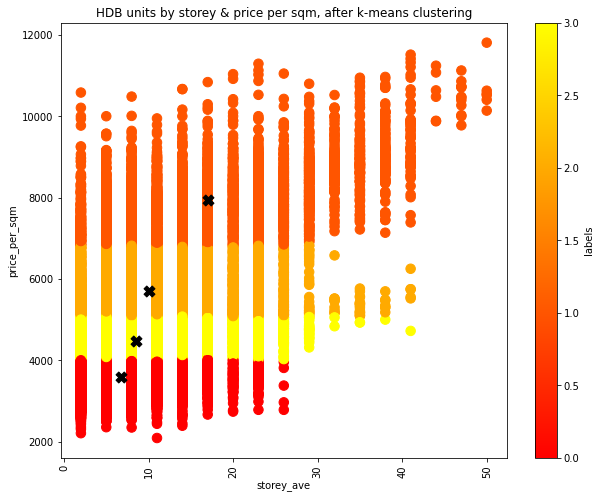

In [51]:
kmeans_fig_1 = plt.figure(figsize=(10, 8))
ax1 = kmeans_fig_1.add_subplot(111)

# Scatter Plot for All Records Colored by Their Labels
df_1_labels.plot(kind='scatter', x='storey_ave', 
               y='price_per_sqm', c='labels', colormap='autumn', ax=ax1
              ,marker="o", s=90)


# Scatter Plot for Centroids
centroids_df_1.plot(kind='scatter', x='storey_ave', 
               y='price_per_sqm', color='black', ax=ax1,
                marker="X", s=120,)

ax1.set_title("HDB units by storey & price per sqm, after k-means clustering")
plt.xticks(rotation=90)
plt.show()

#### From the clusters above, we can see that:
#### a) for the first 28 floors, the distribution of prices are constant across floors, with half of the houses having a price thats' in the highest price category while the other half of houses' prices are rather evenly distributed among the other 4 price categories. 
#### b) from ~28th floor to ~42nd floor there are no flats that fall in the lowest price range. 
#### c) above the 42nd floor, the prices of all houses fall in the most expensive category only. 

### B2. region and price per sqm

In [52]:
df_2 = hdb_data[["area_int", "price_per_sqm"]]
df_2_labels = hdb_data[["area_int", "price_per_sqm"]]
distorsions_2 = []

df_2.head()

,area_int,price_per_sqm
0,3,5272.727273
1,3,3731.343284
2,3,3910.447761
3,3,3897.058824
4,3,3955.223881


Text(0.5, 1.0, 'Elbow curve 2')

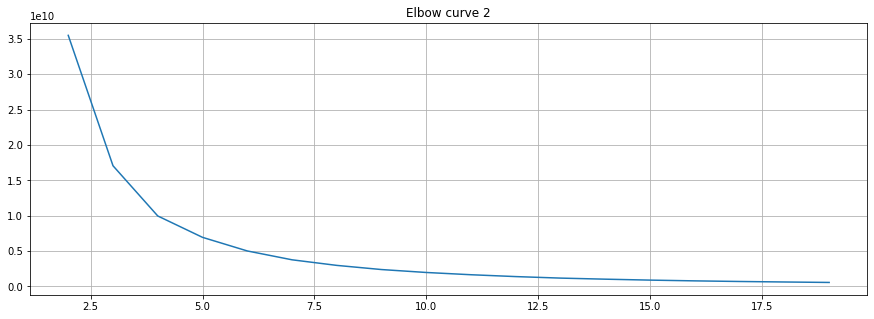

In [53]:
for k in range(2, 20):
    kmeans_2 = KMeans(n_clusters=k)
    kmeans_2.fit(df_2)
    distorsions_2.append(kmeans_2.inertia_)

fig_2 = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions_2)
plt.grid(True)
plt.title('Elbow curve 2')

In [54]:
k_2 = 4
model_2 = KMeans(n_clusters=k_2,  # < Initialise Number Of Clusters here
               random_state=0)

hdb_kmeans_2 = model_2.fit(df_2) # < DataFrame of All Variables


df_2_labels["labels"] = hdb_kmeans_2.labels_
df_2_labels.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,area_int,price_per_sqm,labels
0,3,5272.727273,3
1,3,3731.343284,2
2,3,3910.447761,2
3,3,3897.058824,2
4,3,3955.223881,2


In [55]:
centroids_df_2 = pd.DataFrame(hdb_kmeans_2.cluster_centers_, columns=["area_int", "price_per_sqm"])
centroids_df_2["label"] = centroids_df_2.index

centroids_df_2.head()

,area_int,price_per_sqm,label
0,2.650667,4475.464617,0
1,4.339823,7942.967165,1
2,2.158641,3586.265394,2
3,3.250518,5717.073700,3


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matpl

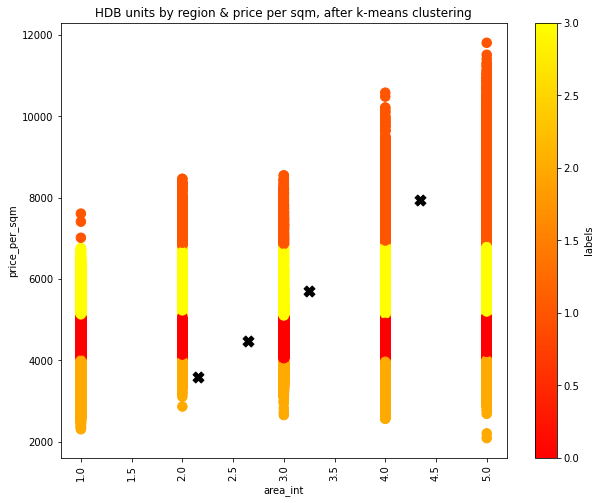

In [56]:
kmeans_fig_2 = plt.figure(figsize=(10, 8))
ax1 = kmeans_fig_2.add_subplot(111)

# Scatter Plot for All Records Colored by Their Labels
df_2_labels.plot(kind='scatter', x='area_int', 
               y='price_per_sqm', c='labels', colormap='autumn', ax=ax1
              ,marker="o", s=90)


# Scatter Plot for Centroids
centroids_df_2.plot(kind='scatter', x='area_int', 
               y='price_per_sqm', color='black', ax=ax1,
                marker="X", s=120,)

ax1.set_title("HDB units by region & price per sqm, after k-means clustering")
plt.xticks(rotation=90)
plt.show()

#### From the visualization above, we can see that the price per square metre of houses are distributed similarly across the North (1), South (2) and East (3) regions in singapore. The west (4) has a slightly higher number of houses in the highest price category, while the Central area has a significantly higher number of houses falling in the most expensive category. 

### B3. flat_type and price_per_sqm

In [57]:
df_3 = hdb_data[["flat_type_int", "price_per_sqm"]]
df_3_labels = hdb_data[["flat_type_int", "price_per_sqm"]]
distorsions_3 = []

df_3.head()

,flat_type_int,price_per_sqm
0,2,5272.727273
1,3,3731.343284
2,3,3910.447761
3,3,3897.058824
4,3,3955.223881


Text(0.5, 1.0, 'Elbow Plot 3')

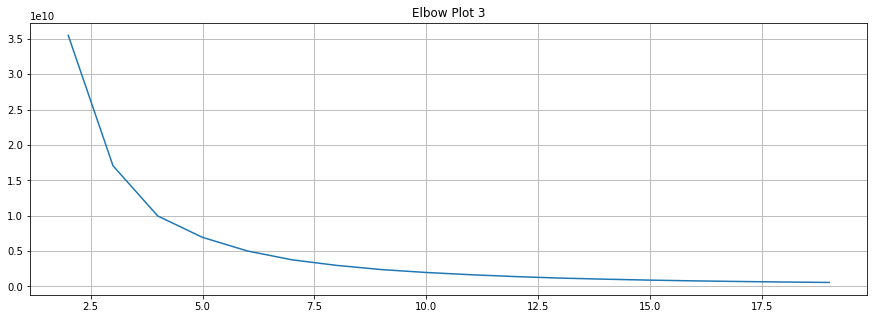

In [58]:
for k in range(2,20):
    kmeans_3 = KMeans(n_clusters=k)
    kmeans_3.fit(df_3)
    distorsions_3.append(kmeans_3.inertia_)

fig_3 = plt.figure(figsize=(15,5))
plt.plot(range(2,20), distorsions_3)
plt.grid(True)
plt.title("Elbow Plot 3")


In [ ]:
k_3 = 4

model_3 = KMeans(n_clusters=k_3,  # < Initialise Number Of Clusters here
               random_state=0)

hdb_kmeans_3 = model_3.fit(df_3) # < DataFrame of All Variables


df_3_labels["labels"] = hdb_kmeans_3.labels_
df_3_labels.head()

In [ ]:
centroids_df_3 = pd.DataFrame(hdb_kmeans_2.cluster_centers_, columns=["flat_type_int", "price_per_sqm"])
centroids_df_3["label"] = centroids_df_3.index

centroids_df_3.head()

In [ ]:
kmeans_fig_3 = plt.figure(figsize=(10, 8))
ax1 = kmeans_fig_3.add_subplot(111)

# Scatter Plot for All Records Colored by Their Labels
df_3_labels.plot(kind='scatter', x='flat_type_int', 
               y='price_per_sqm', c='labels', colormap='autumn', ax=ax1
              ,marker="o", s=90)


# Scatter Plot for Centroids
centroids_df_3.plot(kind='scatter', x='flat_type_int', 
               y='price_per_sqm', color='black', ax=ax1,
                marker="X", s=120,)

ax1.set_title("HDB units by flat_type & price per sqm, after k-means clustering")
plt.xticks(rotation=90)
plt.show()

#### From the clusters above, we can see that almost all 1-bedroom flats (1) fall within the intermediate price per sqm category. The variation in price per sqm increases as the number of rooms in a flat increases from 1 to 5. 

# Conclusion and Insights

To conclude, based on the outputs from the univariate linear regression, we discovered that the Town that the HDB apartment belonged to was the most reliable and significant predictor of the price per square meter. The regression model gave an R-squared value of 47.5% when fed the training data, and 47.1% when fed the testing data. This shows that the regression model was able to account for most of the variance in its prediction. Although this score is not extremely convincing, compared to the other regression that were build (#2 to #3), this regression model #1 yielded the best R-squared score and Mean Squared Error score.

From the k-means models, one can determine the expected price range of their units based on different features. This, however, would be more meaningful for those living in higher floors (for model B1), and 1-bedroom flats or multi-generation apartments (for model B3) as these specific characteristics have more narrow and defined price ranges. Nevertheless, the segmentation of houses into distinct price categories based on these traits can be used by real estate agents for understanding resale prices.